goal: to train a genome-level classifier that predicts whether a genome is a PICI, cfPICI, P4, or phage.

Input for the model: a vector of proteins in each PHROG functional category for a given genome (e.g., number of tail, head, integrase, lysis, etc. proteins). The final output should be a trained model that can classify new genomes based on their PHROG function profiles.

- First, construct training data. The PHROG annotations are already available, so use the true functional categories to construct the input vectors. construct vectprs according to the sequence of proteins; reverse the order if majority of proteins are on the negative strand.
- Once the feature vectors are built for each genome, train a multiclass classifier (like XGBoost or LightGBM).
- Target label: the genome type (PICI, cfPICI, P4, or phage).

whole workflow: 
   Bacterial Genome 
   → Sliding Window 
   → Protein Prediction 
   → PHROG Function Prediction (your trained predictors)
   → Feature Vector Construction 
   → Multi-class Classification

In [1]:
import pandas as pd

# data preparation

In [2]:
annotation = pd.read_parquet("../dataset/Phage_and_Satellites_Pann_Pcat_Pcol.pa")

In [31]:
def get_acc_info(annotation, type: str):
    annotation_type = annotation[annotation["what"] == type]
    acc_df = pd.DataFrame(columns=["acc", "average_strand", "num_proteins"])
    for acc in annotation_type["acc"].unique():
        data = annotation_type[annotation_type["acc"] == acc]
        num_proteins = len(data)
        average_strand = data["strand"].mean()
        acc_df = pd.concat(
            [
                acc_df,
                pd.DataFrame(
                    {
                        "acc": [acc],
                        "average_strand": [average_strand],
                        "num_proteins": [num_proteins],
                    }
                ),
            ],
        )
    return acc_df


acc_pici_df = get_acc_info(annotation, "PICI")
acc_cfpici_df = get_acc_info(annotation, "CFPICI")
acc_p4_df = get_acc_info(annotation, "P4")
# acc_phage_df = get_acc_info(annotation, "phage")

/tmp/ipykernel_1888755/4099752655.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  acc_df = pd.concat(
/tmp/ipykernel_1888755/4099752655.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  acc_df = pd.concat(
/tmp/ipykernel_1888755/4099752655.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 

In [48]:
all_acc = annotation["acc"].unique()
annotation_phage = annotation[annotation["what"] == "phage"]
pici_acc = acc_pici_df["acc"].unique()
cfpici_acc = acc_cfpici_df["acc"].unique()
p4_acc = acc_p4_df["acc"].unique()
phage_acc = annotation_phage["acc"].unique()
print(f"all_acc: {len(all_acc)}")
print(f"pici_acc: {len(pici_acc)}")
print(f"cfpici_acc: {len(cfpici_acc)}")
print(f"p4_acc: {len(p4_acc)}")
print(f"phage_acc: {len(phage_acc)}")

all_acc: 30407
pici_acc: 1435
cfpici_acc: 916
p4_acc: 2097
phage_acc: 25959


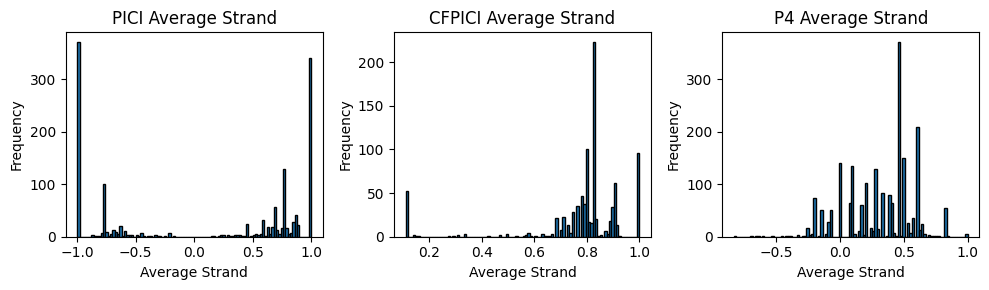

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 3))
plt.subplot(1, 3, 1)
plt.hist(acc_pici_df["average_strand"], bins=100, edgecolor="black")
plt.title("PICI Average Strand")
plt.xlabel("Average Strand")
plt.ylabel("Frequency")

plt.subplot(1, 3, 2)
plt.hist(acc_cfpici_df["average_strand"], bins=100, edgecolor="black")
plt.title("CFPICI Average Strand")
plt.xlabel("Average Strand")
plt.ylabel("Frequency")

plt.subplot(1, 3, 3)
plt.hist(acc_p4_df["average_strand"], bins=100, edgecolor="black")
plt.title("P4 Average Strand")
plt.xlabel("Average Strand")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

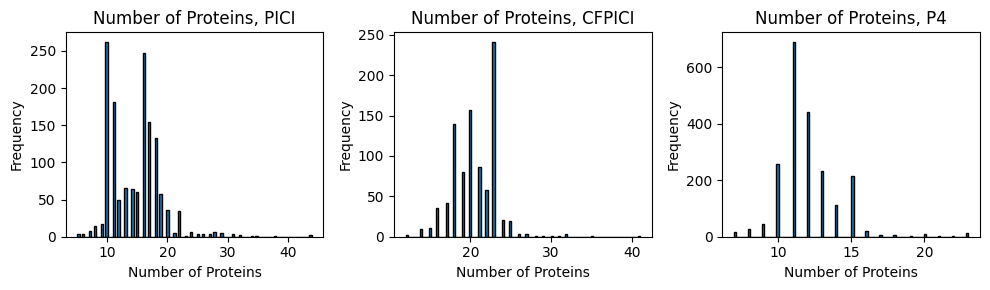

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 3))
plt.subplot(1, 3, 1)
plt.hist(acc_pici_df["num_proteins"], bins=100, edgecolor="black")
plt.title("Number of Proteins, PICI")
plt.xlabel("Number of Proteins")
plt.ylabel("Frequency")

plt.subplot(1, 3, 2)
plt.hist(acc_cfpici_df["num_proteins"], bins=100, edgecolor="black")
plt.title("Number of Proteins, CFPICI")
plt.xlabel("Number of Proteins")
plt.ylabel("Frequency")

plt.subplot(1, 3, 3)
plt.hist(acc_p4_df["num_proteins"], bins=100, edgecolor="black")
plt.title("Number of Proteins, P4")
plt.xlabel("Number of Proteins")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

feature vector

In [ ]:
feature_categories = [
    "DNA_RNA_metabolism",
    "head_and_packaging",
    "tail",
    "connector",
    "lysis",
    "transcription_regulation",
    "integration_excision",
    "moron_auxiliary",
    "other",
    "unknown_function",
    "unknown_no_hit",
]
classes = ["PICI", "cfPICI", "P4", "none"]
# classes = ['PICI', 'cfPICI', 'P4', 'phage', 'none']

In [ ]:
def construct_feature_vector(window_proteins):
    # Initialize counts for each category
    counts = {cat: 0 for cat in feature_categories}

    # Count proteins in each category
    for protein in window_proteins:
        counts[protein.phrog_category] += 1

    # Convert to vector
    return [counts[cat] for cat in feature_categories]